<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WESAD_Debiasing_Classification_Algorithms_1_0_AGE_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Debiasing classification algorithms for Occupational Stress Detection


---


## Content:
Find an introduction to the aim and dataset in the README file.


- **Dataset**
    - WESAD dataset
    - **Sensitve attributes**: age (binary attribute) 
    - Unbalanced representation of groups in sample (sample size disparity)

- **Domain**
    - Operations management - stress detection 

- **ML task**
    - SMV (rbf)
    - LinearClassifier (log)
    - K-NN     

- **Fairness tasks**
    - Assessment of unfairness 
    - Mitigation of unfairness with a focus on equal **FALSE NEGATIVE RATE** and **EQUALIZED ODDS**

- **Model performance metrics**:
    - Confusion matrix
    - Recall, accuracy & precision
    - ROC curves

- **Model fairness metrics**:
    - Equalized odds / False negatives and False negative rate [link](https://fairware.cs.umass.edu/papers/Verma.pdf)
    - Selection Rate

- **Mitigation algorithms**:

*The objective is to reduce false negatives / make them equal (avoid burnout of employees)*

        - Reweighting (aif360 - preprocessing)
        - Exponential gradient (fairlearn - postprocessing)
        - ThresholdOptimizer (fairlearn - postprocessing)


```
# Nomeclature: 

X ∈ Rᵈ: quantified features of the applicant

A ∈ {0, 1}: binary sensitive attribute gender

C :=c(X,A) ∈ {0,1}: binary predictor (stressed vs. ok), which makes decision based on a score R:=r(x, a) ∈ [0,1]

Y ∈ {0, 1}: target variable

```

## BASE CODE

### Libraries

In [1]:
# importing general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import Markdown, display

In [ ]:
! pip install fairlearn
! pip install aif360

### Data load and wrangling

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

In [4]:
# open csv historical data
# if using collab use -->
path = '/content/drive/MyDrive/00 - thesis/Thesis - Fabia Höhne/Datasets/WESAD/m14_merged.csv'

# if using the GitHub repo use -->
# path = './Datasets/WESAD/m14_merged.csv'

df = pd.read_csv(path, sep=',', index_col=0)

In [5]:
# reorder df columns & remove features which will not be used (lifestyle features, 3D data)
# remove min, max values, as mean & st. dev are already calculated
# remove according to corr analysis --> total of 18 attributes left 

cols = ['subject', 'label', 
        'age','gender_ female',
        'height', 'weight', 
        'BVP_std', 
        'EDA_mean', 'EDA_std', 
        'EDA_phasic_mean','EDA_phasic_std', 
        'EDA_smna_mean','EDA_smna_std', 
        'EDA_tonic_mean','EDA_tonic_std',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

df = df[cols]


In [6]:
# rename gender (male:0, female:1)
df = df.rename(columns = {'gender_ female':'gender'})

In [7]:
# remove amusement state 
# 1: baseline, 2: stressed
df = df.loc[~(df['label'] == 0)]

In [8]:
# chang 1,2 classification to 0,1 classification to avoid problems down the line
# 0: baseline, 1: stressed
df['label'] = df['label'].replace({1: 0})
df['label'] = df['label'].replace({2: 1})

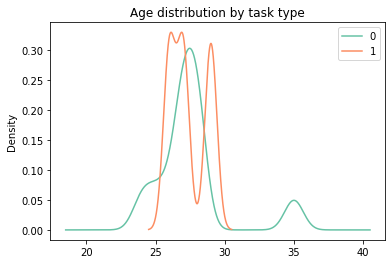

In [9]:
# check gender & age representation 
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Age distribution by task type')
df.groupby('gender').age.plot(kind='kde')
ax.legend()

In [10]:
df.age.mean()

27.482197355035606

In [11]:
# bin age into groups to make binary (0: under 27)
df['age'] = np.where(df['age']>=28, '1', '0')

In [12]:
# check for correctness 
df.head()

,subject,label,age,gender,height,weight,BVP_std,EDA_mean,EDA_std,EDA_phasic_mean,EDA_phasic_std,EDA_smna_mean,EDA_smna_std,EDA_tonic_mean,EDA_tonic_std,Resp_std,TEMP_mean,TEMP_slope
0,2,0,0,0,175,80,107.648359,1.397968,0.141481,1.824289,1.088328,1.284376,1.952823,1.232164,0.997487,2.935617,35.817091,-0.000169
1,2,0,0,0,175,80,118.742089,1.210132,0.091882,2.109146,1.223528,1.467865,2.852510,0.377615,1.172221,2.843123,35.797568,-0.000789
2,2,0,0,0,175,80,42.190039,1.010977,0.102315,0.152828,0.128896,0.105091,0.244891,1.727696,0.293389,1.700333,35.712909,-0.000717
3,2,0,0,0,175,80,41.606872,0.775187,0.046391,0.177595,0.126167,0.110786,0.199704,0.987927,0.042388,1.483260,35.700811,0.000075
4,2,0,0,0,175,80,43.121633,0.657494,0.034540,0.035014,0.039616,0.026716,0.114738,0.772262,0.077628,1.501585,35.744727,0.000442


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1164
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          983 non-null    int64  
 1   label            983 non-null    int64  
 2   age              983 non-null    object 
 3   gender           983 non-null    int64  
 4   height           983 non-null    int64  
 5   weight           983 non-null    int64  
 6   BVP_std          983 non-null    float64
 7   EDA_mean         983 non-null    float64
 8   EDA_std          983 non-null    float64
 9   EDA_phasic_mean  983 non-null    float64
 10  EDA_phasic_std   983 non-null    float64
 11  EDA_smna_mean    983 non-null    float64
 12  EDA_smna_std     983 non-null    float64
 13  EDA_tonic_mean   983 non-null    float64
 14  EDA_tonic_std    983 non-null    float64
 15  Resp_std         983 non-null    float64
 16  TEMP_mean        983 non-null    float64
 17  TEMP_slope     

### Exploratory Analysis

---


We see that there is a clear underrepresentation of women, and peple over 30.

Furthermore, there is a strong correlation between gender & weight/ height. We therefore consider these attributes as a proxy to the sensitve attribute. These attributes will be removed from the equation to allow for unaware training.  

We also see:
- BVP & Resp EDA st.dev. correlatin with age 
- Temp correlation with age & gender


In [14]:
# check for sample distributions
# count subjects by gender, age, label
df.groupby(["gender"])['gender'].count()/66 # on avg. each subject has 66 entries

gender
0    11.863636
1     3.030303
Name: gender, dtype: float64

In [15]:
df.groupby(["age"])['age'].count()/66

age
0    8.848485
1    6.045455
Name: age, dtype: float64

In [16]:
df['label'].value_counts()

0    628
1    355
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


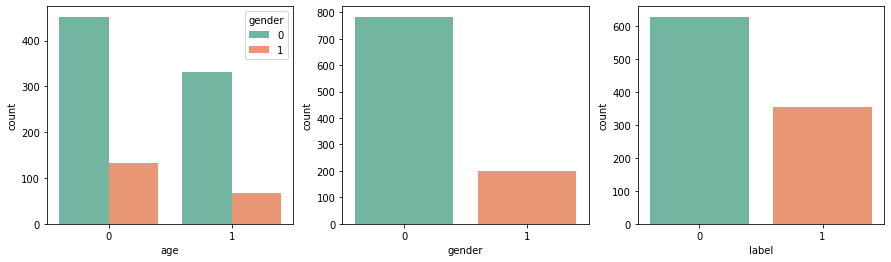

In [17]:
# plot sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15, 4)
sns.countplot(df['age'], ax=ax[0], hue=df.gender)
sns.countplot(df['gender'], ax=ax[1])
sns.countplot(df['label'], ax=ax[2])  ## label 
fig.show()

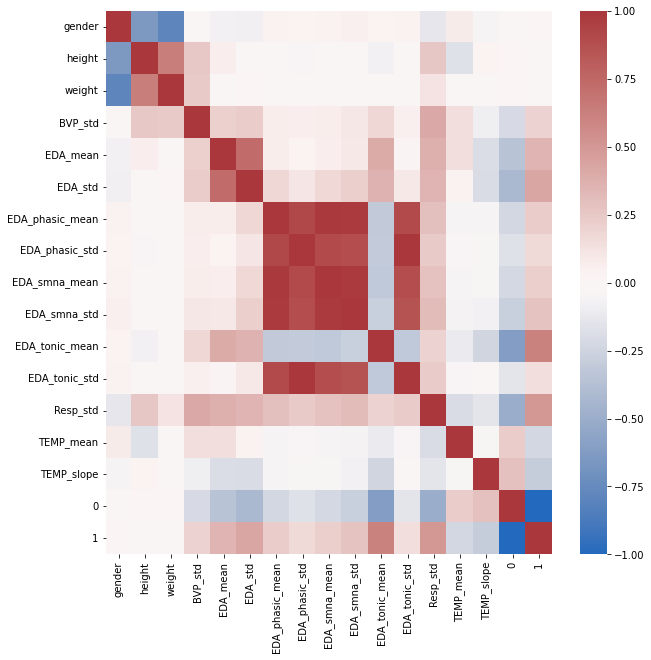

In [18]:
# correlation analysis 
df_corr = pd.concat([df.drop('label', axis=1), pd.get_dummies(df['label'])], axis=1)
df_corr = df_corr.drop('subject', axis =1 )
corr = df_corr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="vlag");

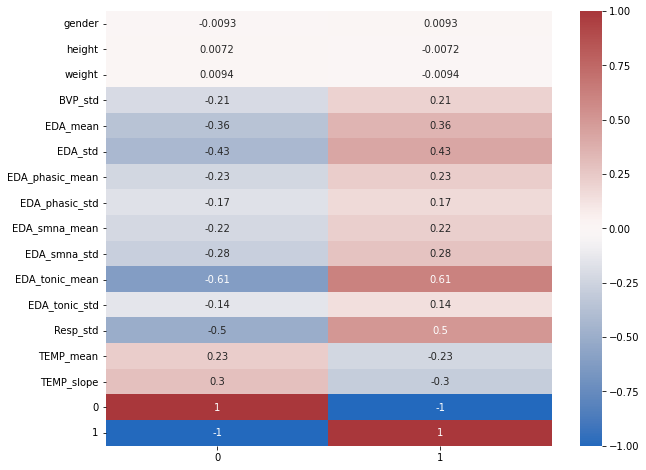

In [19]:
# all features with a corr. under |0.05| are removed 
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('label', axis=1), pd.get_dummies(df[feats]['label'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0, 1]], annot=True, cmap="vlag")

<Figure size 720x720 with 0 Axes>

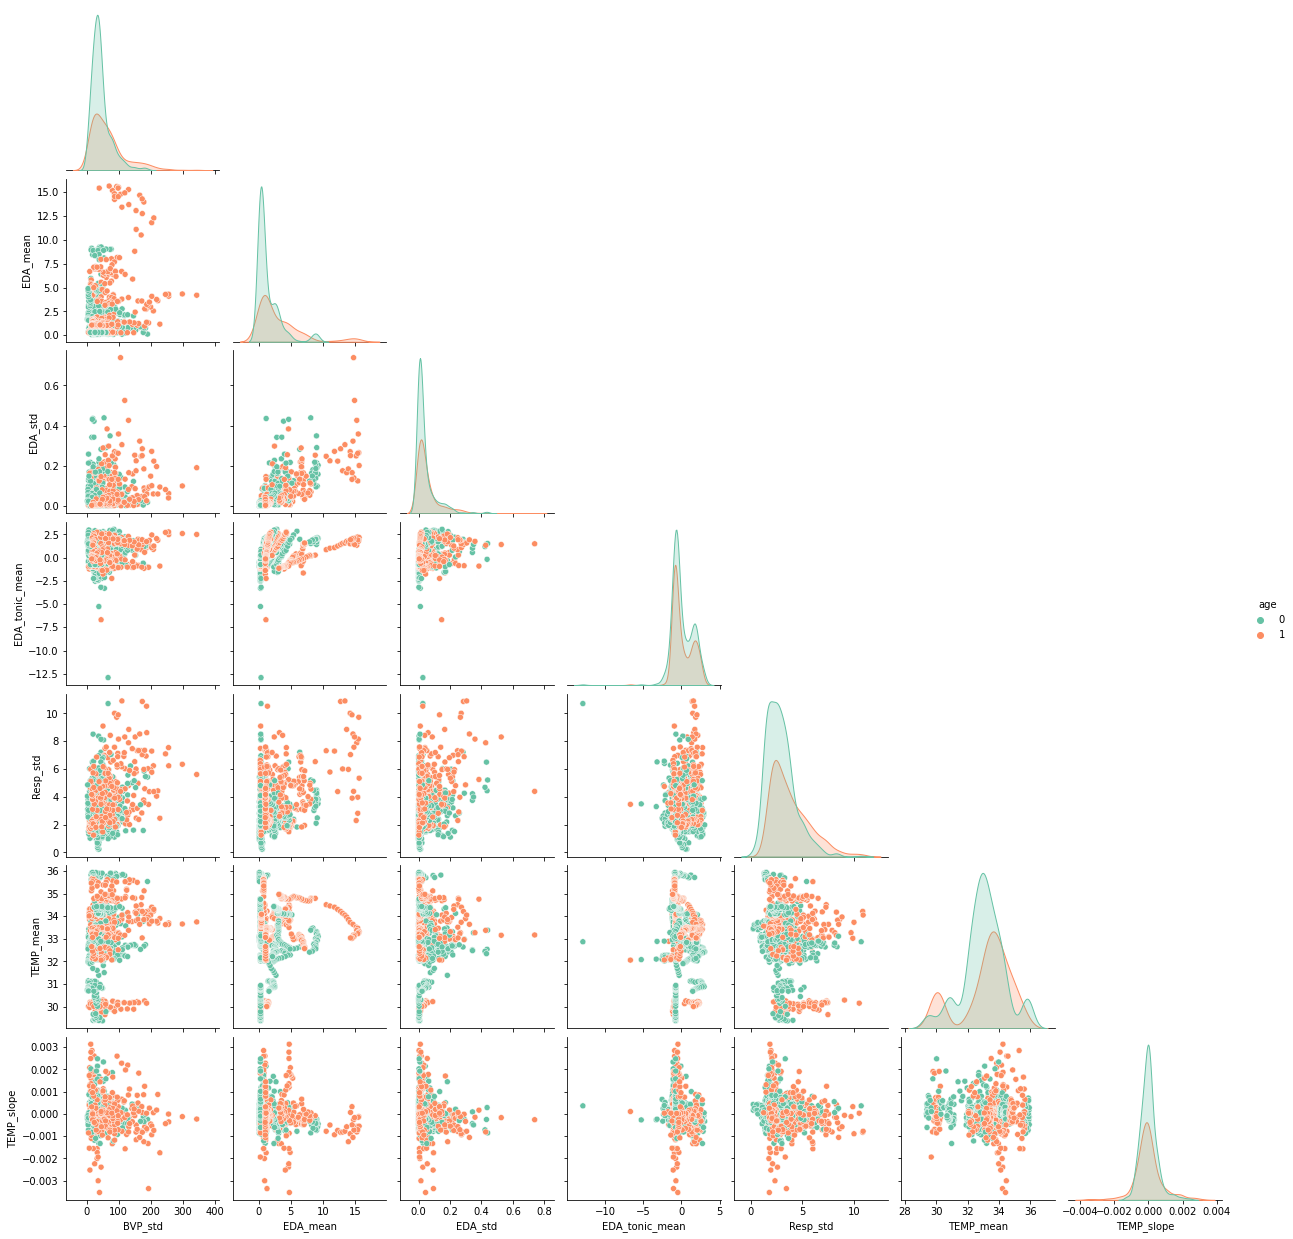

<Figure size 720x720 with 0 Axes>

In [20]:
# to avoid logn processing times, load only most relevant data for pairplot
# check for any anomalies/ trends in correlaitons between attributes

cols2 = ['age',
        'BVP_std', 
        'EDA_mean', 'EDA_std',  
        'EDA_tonic_mean',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

sns.pairplot(df[cols2], hue="age", corner=True)

plt.figure(figsize=(10,10))

## Stress Model
-----


 [Stweard et al. (2020)](https://arxiv.org/pdf/2002.04176.pdf) use the following models to obtain a best- possible generic model for this dataset to detect stress:

- svm (gamma 0.0526) 
- log regression (11 penalization, c=1)
- k-nn (n=20)


#### libraries and helper functions

In [21]:
# libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    PrecisionRecallDisplay)

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

# libraries for fairness
from fairlearn.metrics import MetricFrame
from fairlearn.postprocessing import ThresholdOptimizer


from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference, 
    true_positive_rate, 
    true_negative_rate,
    selection_rate,
    count,
    equalized_odds_difference)

In [22]:
# Helper functions metrics
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Equalized_odds_difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

def metric_frame (feature):
    mf = MetricFrame({
        'FPR': false_positive_rate,
        'FNR': false_negative_rate,
        'TPR': true_positive_rate,
        'TNR': true_negative_rate, },
        y_test, test_preds, sensitive_features = feature)
    return mf.by_group


def summary_as_df(name, summary):
    a = summary.by_group
    a['overall'] = summary.overall
    return pd.DataFrame({name: a})

### Models set-up: test/train split

In [25]:
# simple model - aware (inlc. proxies)
# set test & train data & defining age as sensitive attribute

# unaware: X = df.drop(columns=['gender', 'age', 'label', 'height', 'weight'])

X = df.drop(columns=['label'])
y = df['label']

A = df[['age', 'gender']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 
    test_size = 0.33, 
    random_state=42)

### Model set-up & definition

In [26]:
# set up model:
classifiers = [LogisticRegression(C=1),
               SVC(kernel='rbf', gamma = 0.0526, probability = True),
               KNeighborsClassifier(n_neighbors=20),]


### Model performance evaluation

##### Confusion matrix (test/ train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_

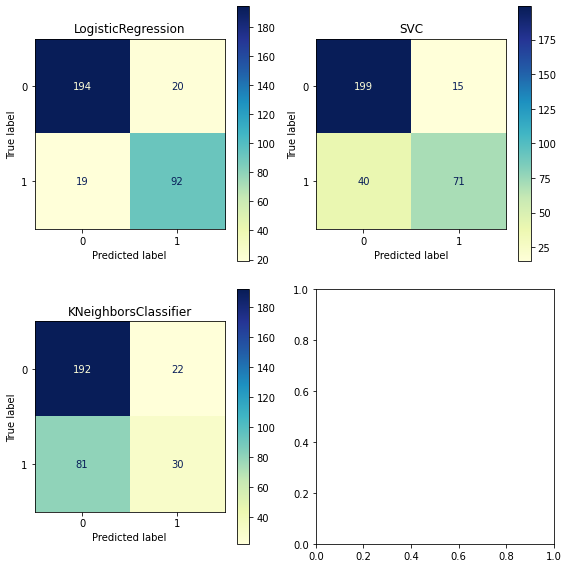

In [27]:
# test set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

In [ ]:
# double check with train set
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for cls, ax in zip(classifiers, axes.flatten()):
    cls.fit(X_train, y_train)
    plot_confusion_matrix(cls, 
                          X_train, 
                          y_train, 
                          
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()
plt.show()

##### Cross Validation

In [ ]:
# train model, get accuracies and CV
groups = X_test['subject']
gkf = GroupKFold(n_splits=4)

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  scores = cross_val_score(model, X_test, y_test, cv=gkf, groups=groups, scoring='accuracy')
  print (f'{model}  {chr(10)} CV: {scores.mean()} {chr(10)}')

##### Classification report

In [30]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(f'{model}: {chr(10)} {classification_report(y_test, y_pred)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=1): 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       214
           1       0.82      0.83      0.83       111

    accuracy                           0.88       325
   macro avg       0.87      0.87      0.87       325
weighted avg       0.88      0.88      0.88       325

SVC(gamma=0.0526, probability=True): 
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       214
           1       0.83      0.64      0.72       111

    accuracy                           0.83       325
   macro avg       0.83      0.78      0.80       325
weighted avg       0.83      0.83      0.82       325

KNeighborsClassifier(n_neighbors=20): 
               precision    recall  f1-score   support

           0       0.70      0.90      0.79       214
           1       0.58      0.27      0.37       111

    accuracy                           0.68       325
   macro avg       0.6

##### Precision recall

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


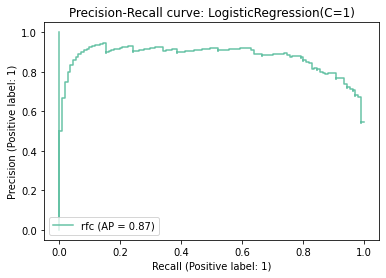

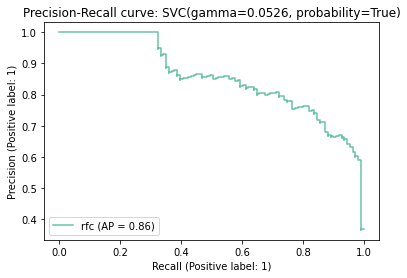

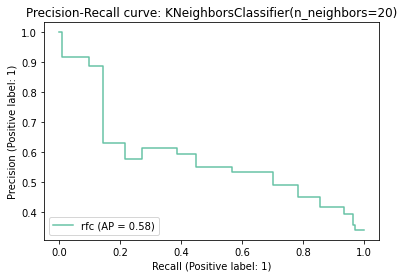

In [31]:
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, name="rfc")
  _ = display.ax_.set_title(f'Precision-Recall curve: {model}')

### Model fairness evaluation

##### Metric Frames

In [32]:
# define sensitive attributes
age =  A_test['age']


for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  print(f'Age:{chr(10)}{model}: {chr(10)} {metric_frame (age)} {chr(10)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


Age:
LogisticRegression(C=1): 
           FPR       FNR       TPR       TNR
age                                        
0       0.125  0.044118  0.955882     0.875
1    0.106383   0.27907   0.72093  0.893617 

Age:
SVC(gamma=0.0526, probability=True): 
           FPR       FNR       TPR       TNR
age                                        
0    0.108333  0.191176  0.808824  0.891667
1    0.255319  0.093023  0.906977  0.744681 

Age:
KNeighborsClassifier(n_neighbors=20): 
           FPR       FNR       TPR       TNR
age                                        
0        0.15  0.441176  0.558824      0.85
1    0.351064  0.418605  0.581395  0.648936 



/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/fairlearn/metrics/_metric_frame.py:67: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  FutureWarning)


##### Fairness metrics by group (equalized odds, demographic parity difference & ratio, false negative rate difference)

In [33]:
# Metrics 
for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"Unmitigated": (test_preds, y_pred)}

  print(f'Age:{chr(10)}{model}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Age:
LogisticRegression(C=1): 
                                Unmitigated
Equalized_odds_difference         0.234952
False negative rate difference    0.234952
Balanced error rate difference    0.108168
 ------                                   
Demographic parity difference     0.126262
  ------                                  
Overall AUC                       0.951419
AUC difference                    0.016475 

Age:
SVC(gamma=0.0526, probability=True): 
                                Unmitigated
Equalized_odds_difference         0.142376
False negative rate difference    0.112859
Balanced error rate difference    0.014758
 ------                                   
Demographic parity difference     0.099511
  ------                                  
Overall AUC                       0.919782
AUC difference                    0.023928 

Age:
KNeighborsClassifier(n_neighbors=20): 
                                Unmitigated
Equalized_odds_difference         0.201064
False negative 

##### visualisation help

In [34]:
# demographic disparity
# https://github.com/fairlearn/fairlearn/blob/main/notebooks/Mitigating%20Disparities%20in%20Ranking%20from%20Binary%20Data.ipynb

from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2 
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

#### visualisation

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


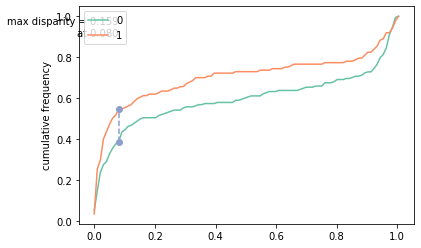

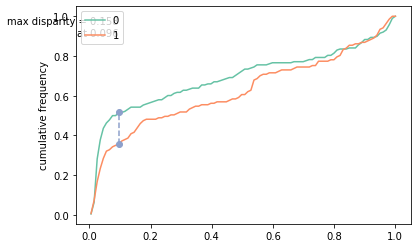

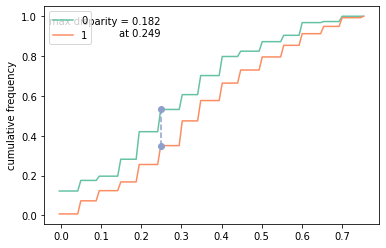

In [35]:
%matplotlib inline

for model in classifiers:
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  # scores on test set
  y_pred = model.predict_proba(X_test)[:, 1]

  # predictions (0 or 1) on test set
  test_preds = (y_pred >= np.mean(y_train)) * 1


  display(HTML('<span id="disparity_unmitigated">'))
  plot_and_compare_cdfs(y_pred, age)
  display(HTML('</span>'))

# Debiasing the model

---




Are we minitating bias (removing the problematic signal) - OR adding inclusion (add singal for deasired features for a re-weighted singal improved fairness?


Bias can come from the acutal data or the algorithm (this includes technical bias from data processing & amplified bias from the feedback loops)



pre-processing: suprression, class relabeling, reweighing, data transportation, database reparis, data augmentation


#### libraries and functions

In [36]:
import aif360

from aif360.datasets import StandardDataset
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import DatasetMetric

from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing import PrejudiceRemover

# fairlearn libraries
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation

from fairlearn.reductions import (ExponentiatedGradient, 
                                  EqualizedOdds, 
                                  ErrorRateParity)

In [38]:
# define for the metric frame
metrics = {
    'accuracy': accuracy_score,
    'false positive rate': false_positive_rate,
    'false negative rate': false_negative_rate,
    'selection rate': selection_rate,
    'count': count,
    'balanced error rate': balanced_accuracy_score}


#### 1. Reweigh samples for age (AIF360)

Based on:
1. [Correcting Unfair Binary Classification
Models](http://arno.uvt.nl/show.cgi?fid=157880)

2. [AIF360 example](https://nbviewer.org/github/IBM/AIF360/blob/master/examples/tutorial_credit_scoring.ipynb)


In [ ]:
# works only for SVM & log reg (knn doesnt do sample weights)
# set dataset in aif360 format
ds_aif = aif360.datasets.StandardDataset (df, 
                                         label_name="label",
                                         favorable_classes = [1], 
                                         protected_attribute_names=['age'], 
                                         privileged_classes= [lambda x: x == 0],
                                         features_to_drop=['subject'])

In [40]:
# test, train split
ds_train, ds_test = ds_aif.split([0.67], shuffle=True)

In [ ]:
# pre-processing - reweighing 
# define priviledged & unpriviledged groups
unpriv = [{'age': 1}]
priv = [{'age': 0}]

# for age change gender lavel to age 

# reweigh
RW = Reweighing (unprivileged_groups = unpriv, 
                 privileged_groups = priv)

RW_train = RW.fit_transform(ds_train)

In [42]:
# check for metric before and after transforming 
# OG ds
metric_train = BinaryLabelDatasetMetric(ds_train,
                                        unprivileged_groups = unpriv,
                                        privileged_groups = priv)

explainer_train = MetricTextExplainer(metric_train)

# transpormed ds
metric_transf_train = BinaryLabelDatasetMetric(RW_train,
                                               unprivileged_groups=unpriv,
                                               privileged_groups=priv)

explainer_transf_train = MetricTextExplainer(metric_transf_train)

In [43]:
# refit rfc model & get metrics
X_train = RW_train.features
y_train = RW_train.labels.ravel()
w_train = RW_train.instance_weights

X_test = ds_test.features
y_test = ds_test.labels.ravel()

###### evaluations

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


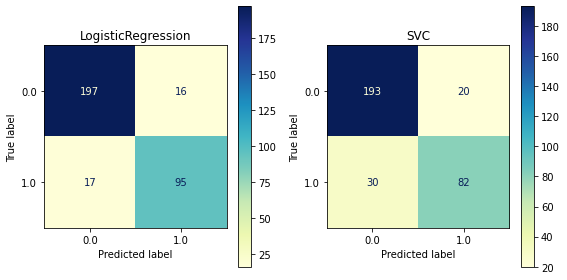

In [44]:
# test models with reweighted data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

for cls, ax in zip(classifiers, axes.flatten()):
    dataset = RW_train
    cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
    
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap='YlGnBu')
    ax.title.set_text(type(cls).__name__)

plt.tight_layout()
plt.show()

In [45]:
for cls in classifiers:
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = w_train)
  y_pred = cls.predict(X_test)
  
  print(f'{cls}: {chr(10)} {classification_report(y_test, y_pred)}')

# expect an error - K-NN does not have sample weights
# re-defining the classifiers will erset the random seed, which leads to non-comparable results

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1): 
               precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       213
         1.0       0.86      0.85      0.85       112

    accuracy                           0.90       325
   macro avg       0.89      0.89      0.89       325
weighted avg       0.90      0.90      0.90       325

SVC(gamma=0.0526, probability=True): 
               precision    recall  f1-score   support

         0.0       0.87      0.91      0.89       213
         1.0       0.80      0.73      0.77       112

    accuracy                           0.85       325
   macro avg       0.83      0.82      0.83       325
weighted avg       0.84      0.85      0.84       325



TypeError: ignored

###### fairness evaluations

In [46]:
# define test 
ds_test_pred = ds_test.copy(deepcopy=True)

In [47]:
for cls in classifiers:
  dataset = RW_train
  cls.fit(dataset.features, dataset.labels.ravel(), sample_weight = dataset.instance_weights)
  y_pred = cls.predict(X_test)
  
  # scores on test set
  ds_test_pred.scores = cls.predict_proba(X_test)[:1]

  # predictions (0 or 1) on test set
  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f'Gender:{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, age)} {chr(10)}') # change age<> gender
  print(f'Gender:{chr(10)}{cls}: {chr(10)} {metric_frame (age)} {chr(10)}') # change age<> gender


  mf1 = MetricFrame(metrics=metrics,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=age)

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
  print(f"{cls}:\n {mf1.by_group}\n")
  print(f"{cls} difference:\n {mf1.difference(method='between_groups')}\n")

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


Gender:
LogisticRegression(C=1): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.138095
False negative rate difference                 0.138095
Balanced error rate difference                 0.058254
 ------                                                
Demographic parity difference                  0.110926
  ------                                               
Overall AUC                                    0.886548
AUC difference                                 0.058254 

Gender:
LogisticRegression(C=1): 
           FPR       FNR       TPR       TNR
age                                        
0    0.084746       0.1       0.9  0.915254
1    0.063158  0.238095  0.761905  0.936842 

LogisticRegression(C=1):
      accuracy false positive rate false negative rate selection rate count  \
age                                                                          
0    0.909574            0.084746                 0.1       0.38

You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


TypeError: ignored

#### Fair learn - post processign methods -- wrappers



In [49]:
# set test & train data & defining age as sensitive attribute - UNAWARE

X = df.drop(columns=['gender', 'age', 'label', 'height', 'weight'])
y = df['label']

A = df[['age']]

# for fairnes measures (inlc. A for group classification, drop age to make it unaware to other senstive attributes (fairnes through unawarenes)) - AGE 
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X, 
    y, 
    A, 

    test_size = 0.33, 
    random_state=42)


#### 3. ExponentiatedGradient - reduction (fair learn)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to 

LogisticRegression(C=1):
     ExponentiatedGradient                                          \
                 accuracy false positive rate false negative rate   
age                                                                 
0                0.920213               0.075            0.088235   
1                0.854015            0.074468            0.302326   

                                              
    selection rate count balanced error rate  
age                                           
0          0.37766   188            0.918382  
1         0.270073   137            0.811603  

LogisticRegression(C=1) difference:
 accuracy               0.066198
false positive rate    0.000532
false negative rate     0.21409
selection rate         0.107587
count                        51
balanced error rate    0.106779
dtype: object



X has feature names, but LogisticRegression was fitted without feature names


ValueError: ignored

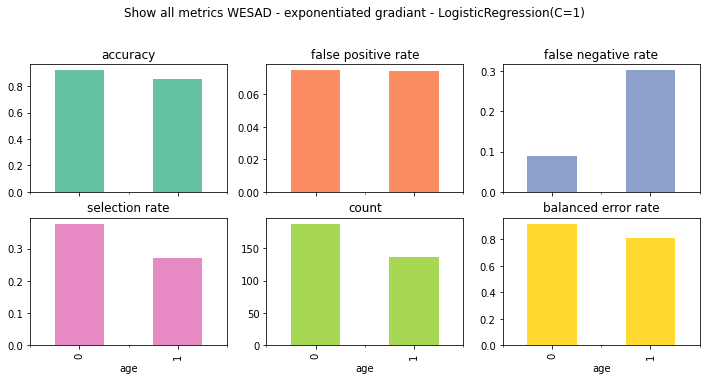

In [50]:
for cls in classifiers:
  expgrad_est = ExponentiatedGradient(estimator=cls,
                                    constraints=ErrorRateParity(difference_bound=0.01)) 
  
  expgrad_est.fit(X_train, y_train, sensitive_features=A_train)
  
  y_pred_reductions = expgrad_est.predict(X_test, random_state=42)
  
  mf_eg =  MetricFrame(metrics=metrics,
                                       y_true=y_test,
                                       y_pred=y_pred_reductions,
                                       sensitive_features=A_test
                                       ) 
  df_results = pd.concat([mf_eg.by_group],
                          keys=['ExponentiatedGradient'],
                          axis=1)
  
  print (f'{cls}:{chr(10)} {df_results}{chr(10)}')
  print(f"{cls} difference:\n {mf_eg.difference(method='between_groups')}\n")


  # visualize mitigated
  mf_eg.by_group.plot(
      kind="bar",
  #    ylim=[0, 1],
      subplots=True,
      layout=[3, 3],
      legend=False,
      figsize=[12, 8],
      title=f'Show all metrics WESAD - exponentiated gradiant - {cls}',
  )



  y_train_pred = cls.predict(X_train)
  test_preds = (y_pred_reductions >= np.mean(y_train)) * 1

  models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

  print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') # change age<> gender

#### 4. Thresholdoptimizer (fair learn - post processing)

ThresholdOptimizer takes in an exisiting (possibly pre-fit) machine learning model whose predictions act as a scoring function and identifies a separate thrceshold for each group in order to optimize some specified objective metric (such as balanced accuracy) subject to specified fairness constraints (such as false negative rate parity). Thus, the resulting classifier is just a suitably thresholded version of the underlying machinelearning model.

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(C=1):
     ThresholdOptimizer                                                         \
              accuracy false positive rate false negative rate selection rate   
age                                                                             
0             0.893617            0.116667            0.088235       0.404255   
1             0.846715             0.06383            0.348837       0.248175   

                               
    count balanced error rate  
age                            
0     188            0.897549  
1     137            0.793667  

LogisticRegression(C=1) difference:
 accuracy               0.046902
false positive rate    0.052837
false negative rate    0.260602
selection rate          0.15608
count                        51
balanced error rate    0.103883
dtype: object

:
LogisticRegression(C=1): 
                                mitigated_pre-processing
Equalized_odds_difference                      0.260602
False negative rate di

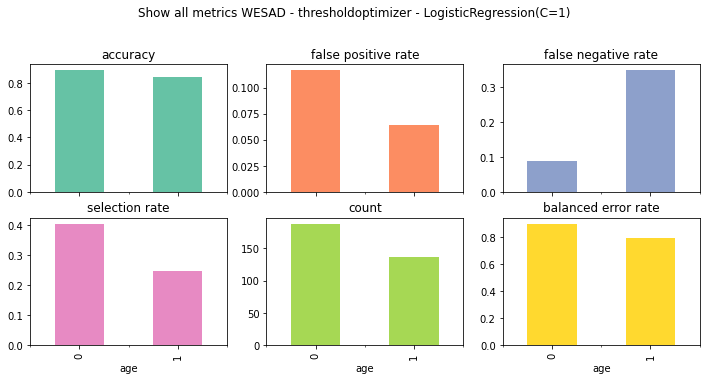

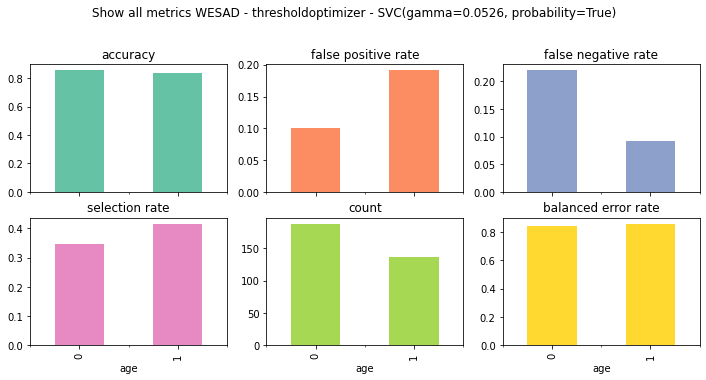

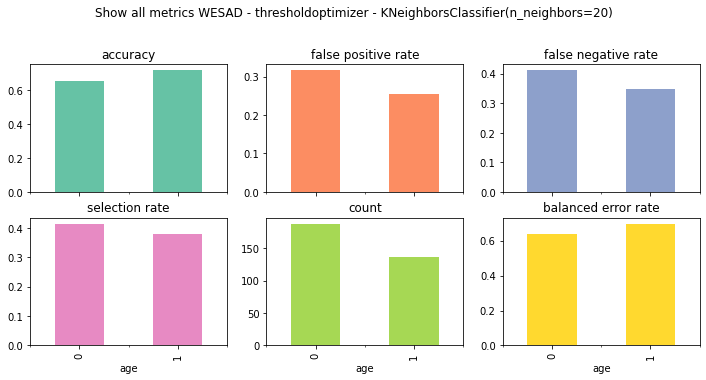

In [51]:
for cls in classifiers:
    unmitigated_pipeline = Pipeline(steps=[("model", cls)])

    unmitigated_pipeline.fit(X_train, y_train)
    
    postprocess_est = ThresholdOptimizer(estimator=unmitigated_pipeline,
                                        constraints="equalized_odds",
                                        objective="balanced_accuracy_score",
                                        prefit=True,
                                        predict_method='predict_proba')
    
    postprocess_est.fit(X_train, y_train, sensitive_features=A_train) # change a test in train/ test sample

    y_pred_postprocess = postprocess_est.predict(X_test, sensitive_features=A_test) 

    mf_to = MetricFrame(metrics=metrics,
                                          y_true=y_test,
                                          y_pred=y_pred_postprocess,
                                          sensitive_features=A_test) 
    
    df_results = pd.concat([mf_to.by_group],
                            keys=['ThresholdOptimizer'],
                            axis=1)

    print (f'{cls}:{chr(10)} {df_results}{chr(10)}')

    print(f"{cls} difference:\n {mf_to.difference(method='between_groups')}\n")
    
    y_train_pred = cls.predict(X_train)
    test_preds = (y_pred_postprocess >= np.mean(y_train)) * 1

    models_dict = {"mitigated_pre-processing": (test_preds, y_pred)}

    print(f':{chr(10)}{cls}: {chr(10)} {get_metrics_df(models_dict, y_test, A_test)} {chr(10)}') 

    # visualize mitigated
    mf_to.by_group.plot(
        kind="bar",
    #    ylim=[0, 1],
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title=f'Show all metrics WESAD - thresholdoptimizer - {cls}',
    )


  